In [ ]:
!pip install tensorflow matplotlib seaborn scikit-learn

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityasharma01/snake-dataset-india")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/snake-dataset-india


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [ ]:
# Constants
img_width, img_height = 224, 224
batch_size = 32
num_classes = 2
epochs = 20

In [ ]:
# Load and preprocess the dataset
def load_dataset(train_dir, test_dir):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Important for confusion matrix
    )
    return train_generator, test_generator

In [ ]:

# Create the model
def create_model(fine_tune=False):
    base_model = MobileNetV2(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')

    # Freeze or unfreeze base model layers
    base_model.trainable = fine_tune

    model = keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
# Plot accuracy
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, cmap='Blues', fmt='.2f')
    plt.title('Confusion Matrix')
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [ ]:
# Predict single image
def predict_image_class(model, image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    return 'venomous' if predicted_class == 1 else 'non-venomous'


In [ ]:
# Paths
train_dir = '/root/.cache/kagglehub/datasets/adityasharma01/snake-dataset-india/versions/6/Snake Images/train'
test_dir = '/root/.cache/kagglehub/datasets/adityasharma01/snake-dataset-india/versions/6/Snake Images/test'

In [ ]:
# Load data
train_generator, test_generator = load_dataset(train_dir, test_dir)

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.2412587412587412), 1: np.float64(0.8372641509433962)}


In [ ]:
# Create model
model = create_model(fine_tune=False)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8017 - loss: 0.4187 - val_accuracy: 0.8359 - val_loss: 0.3696
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.7188 - loss: 0.4547 - val_accuracy: 0.8281 - val_loss: 0.3731
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8361 - loss: 0.3588 - val_accuracy: 0.8398 - val_loss: 0.3460
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - accuracy: 0.8438 - loss: 0.3890 - val_accuracy: 0.8398 - val_loss: 0.3423
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8452 - loss: 0.3347 - val_accuracy: 0.8672 - val_loss: 0.3280
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.8438 - loss: 0.3269 - val_accuracy: 0.8711 - val_loss: 0.3259
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.8634 - loss: 0.3045 - val_accuracy: 0.8477 - val_loss: 0.3270
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 552ms/step - accuracy: 0.9375 - loss: 0.1655 - val_accuracy: 0.

In [ ]:
# Evaluate model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)

8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7883 - loss: 0.4592
Test accuracy: 0.80859375


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: venomous


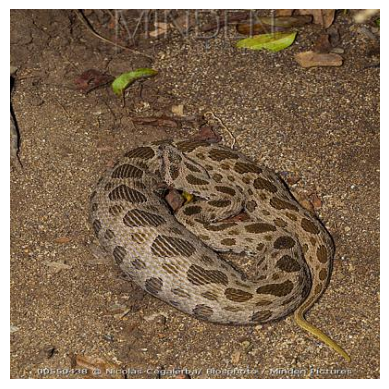

In [ ]:
# Predict single image
import matplotlib.pyplot as plt
image_path = '/root/.cache/kagglehub/datasets/adityasharma01/snake-dataset-india/versions/6/Snake Images/test/Venomous/00550438.jpg'
predicted_class = predict_image_class(model, image_path)
print('Predicted class:', predicted_class)
img = keras.preprocessing.image.load_img(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

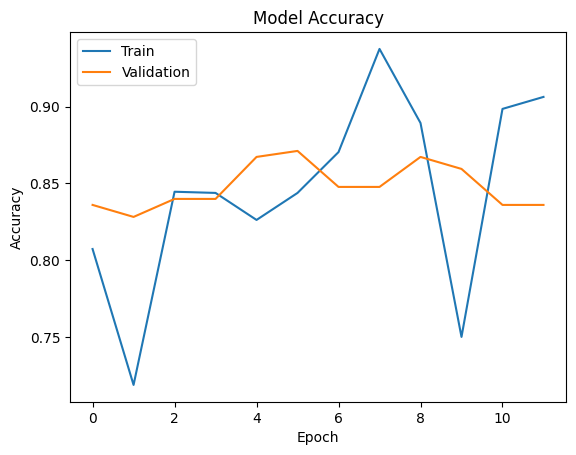

In [ ]:
# Accuracy graph
plot_accuracy(history)

9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step


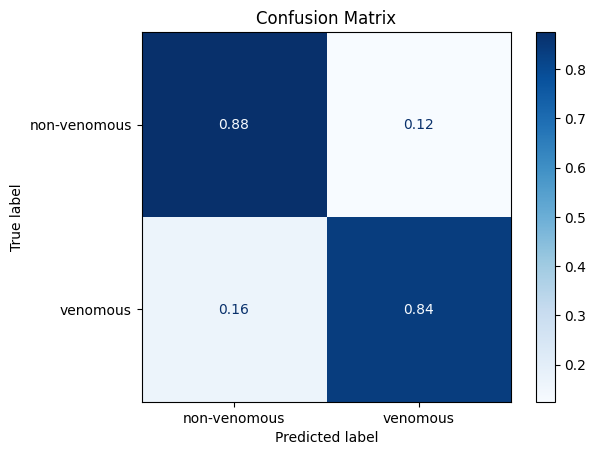

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Reset the generator
test_generator.reset()

# Get predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class names (adjust if needed)
class_names = ['non-venomous', 'venomous']

# Compute normalized confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

non-venomous       0.83      0.88      0.85       128
    venomous       0.88      0.84      0.86       141

    accuracy                           0.86       269
   macro avg       0.86      0.86      0.85       269
weighted avg       0.86      0.86      0.86       269

